# Using Reddit's API for Predicting From Which Subreddit a Post Comes

### Scraping data from subreddits

> I chose to compare two subreddits related to QUEENS.  My topic is to train a computer to tell the difference between a post from the Rupaul Drag Race subreddit (r/rupauldragrace) versus a post from a subreddit that is generally focused on royal families (r/monarchist).

> I collected data at three points in time using the routine below.  I then have code that combines the scraped data into one dataframe and deletes duplicate data.  Overall, I ended up with approximately 1400 posts for my target subreddit (RDR) and almost 1000 posts for the other class, general monarchy posts.

> Additionally, I have scraped a third subreddit, a discussion forum on the Netflix show The Crown (r/thecrown).  At the end of the exercise, I want to see if this post about this show resemble more closely posts from the RDR forum or the general monarchy forum.

In [32]:
# load libraries that will be used throughout the notebook

import json
import re
import requests
import time

import pandas as pd

from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

from bs4 import BeautifulSoup             
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline

> Select which subreddit to pull data from.  Set header for the reddit API

In [2]:
url = "https://www.reddit.com/r/rupaulsdragrace.json"
#url = "https://www.reddit.com/r/monarchism.json"
#url = 'https://www.reddit.com/r/TheCrownNetflix.json'

header = {'User-agent': 'Scott data science student project 0.2'}

> The follwing code take 40 loops through the data to collect up to a 1000 posts.  Note that the reddit API only allows the most recent 1000 posts to be scraped, 25 at a time.  This loop maximizes the amount of data collected in one turn.  The print statements (now commented out) were useful in showing progress as the files were scrapped.
#### This code is only run if additional data scraping is desired.  After data is scraped, the user only needs to load the data from the CSV files, and proceed to the modeling steps.

In [3]:
posts = []
last = None
for j in range(40):
    if last == None:
        param = {}
    else:
        param = {'after':last}
    result = requests.get(url, params = param, headers = header)
    if result.status_code == 200:
        data = result.json()
        posts.extend(data['data']['children'])
        last = data['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(1)

> The object posts is a list of dictionaries.  Each dictionary in the list contains a key 'data' which then accesses another dictionary.  This second dictionary contains the post data.  The code below iterates through the posts list, extracts the embedded dictionary, creates a Pandas dataframe, and then writes the data to a CSV file so that it can be used later in the process.

In [4]:
post_dict = [each['data'] for each in posts]
post_df = pd.DataFrame(post_dict)
#fileout = './datasets/thecrown.csv'
fileout = './datasets/ru_friday3.csv'
#fileout = './datasets/royal_wednesday.csv'
post_df.to_csv(fileout, index = False)

### Load scraped data from CSV files

> The code below loads the files created as the data was scraped from reddit.  It then combines the files (in order from most recent to oldest), fills null values, drops duplicates, and then creates the datafield X which is a combination of the title of a post plus the text that goes along with the title.

> It was required to fill null values because combining the title and post text returned a null value if either the title or text was null.  A space was inserted instead of a null which will not influence the NLP analysis.

> Although the code looks repetitive, it was generated over the course of two weeks where new lines were added in as new data was collected.  It didn't make sense to go back after the fact to create functions.

> The last block of code in this section puts the class labels on to the data (1 = RDR, 0 = general monarchy).  And then combines all of the data into one dataset so that it can then be passed to train test split.

In [5]:
# Load save CSV files
post_df1 = pd.read_csv('./datasets/ru.csv')          # ru.csv is from r/rupaulsdragrace
post_df2 = pd.read_csv('./datasets/royal.csv')       # This royal.csv is from r/monarchism
post_df1a = pd.read_csv('./datasets/ru_Sun.csv') 
post_df2a = pd.read_csv('./datasets/royal_Sun.csv') 
post_df1b = pd.read_csv('./datasets/ru_wednesday.csv')
post_df2b = pd.read_csv('./datasets/royal_wednesday.csv')
post_df3 = pd.read_csv('./datasets/thecrown.csv')

# Combine files 
post_df1 = post_df1a.append(post_df1)
post_df2 = post_df2a.append(post_df2)
post_df1 = post_df1b.append(post_df1)
post_df2 = post_df2b.append(post_df2)

# Fill null values with spaces
post_df1.fillna(' ', inplace = True)
post_df2.fillna(' ', inplace = True)
post_df3.fillna(' ', inplace = True)

# Create one column with the text to be analyzed
post_df1['X'] = post_df1['title'] + ' ' + post_df1['selftext']
post_df2['X'] = post_df2['title'] + ' ' + post_df2['selftext']
post_df3['X'] = post_df3['title'] + ' ' + post_df3['selftext']

# Drop duplicate records -- highly likely since scrapes happened at various points in two weeks
post_df1.drop_duplicates(subset = ['X'], keep = 'first', inplace = True)
post_df2.drop_duplicates(subset = ['X'], keep = 'first', inplace = True)
post_df3.drop_duplicates(subset = ['X'], keep = 'first', inplace = True)

# Prep data so that modeling process can begin.
post_df1['subred'] = 1   # 1 indicates subreddit RuPaul's drag race
post_df2['subred'] = 0   # 0 indicates subreddit Monarchy
X = post_df1[['X']]
y = post_df1[['subred']]
X = X.append(post_df2[['X']])
y = y.append(post_df2[['subred']])
X.reset_index(drop= True, inplace = True)            # Since the two subreddits had overlapping indices
y.reset_index(drop= True, inplace = True)            # need to reset so that there are no conflicts
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### Find mean of y so that we know the minimum performance of any model.

> Given the mean is around 60%, any model that has an accuracy of around 60% is a very poor model.  Labeling all posts as 1 would produce this level of accuracy without any NLP analysis.

In [6]:
print(y_train.mean())
print(y_test.mean())

subred    0.597738
dtype: float64
subred    0.596774
dtype: float64


## Data Prep / Cleansing

> The following data prep routine was used to prepare the data for analysis.

> I did sensitivity test certain cleaning protocol to see if the impact on model accuracy.  For example, I turned Lemmatizing off and noticed poorer model performance.  I also kept stop words in place but again noticed (significant) model deterioration.

> Many of these tasks could be handled by the models themselves, but I liked the idea of controlling the cleaning process.  Additionally, doing this step at the beginning allowed me to run multiple passes of the models without repeating these tasks each time.

In [7]:
def data_prep(text_in):      
    text_out = text_in.lower()                           #change everything to lower case
    text_out = re.sub("\\n", ' ', text_out)              #replace end of line \n with space
    text_out = re.sub("\.[0-9a-z]+ ", ' ', text_out)     #eliminate .abc231 constucts
    text_out = re.sub("[^a-z ]", '', text_out)           #if not text, remove
    tokenizer = RegexpTokenizer('\w+')                   #instantiate Tokenizer
    list_out = tokenizer.tokenize(text_out)              #split into words
    lemmatizer = WordNetLemmatizer()                     #instantiate lemmatizer
    list_out = [lemmatizer.lemmatize(each) for each in list_out]
    list_out = [each for each in list_out if each not in stopwords.words('english')]
    return  (' '.join(list_out))                         #smash words back together

In [8]:
X_tr_f = X_train['X'].apply(data_prep)
X_te_f = X_test['X'].apply(data_prep)
X_crown = post_df3['X'].apply(data_prep)

### EDA on training data

> Remove any entries where the post is blanks.  This can happen if the post only contained stop words.

In [9]:
trn = pd.DataFrame({
    'X':X_tr_f,
    'y':y_train['subred']
})

rmv = list(trn[trn['X'] == ''].index)

trn.drop(labels = rmv, axis = 0, inplace = True)

X_tr_f = trn['X']
y_train = trn[['y']]

trn = pd.DataFrame({
    'X':X_te_f,
    'y':y_test['subred']
})

rmv = list(trn[trn['X'] == ''].index)
trn.drop(labels = rmv, axis = 0, inplace = True)

X_te_f = trn['X']
y_test = trn[['y']]

> Look at most common words, which subreddit they came from, etc.

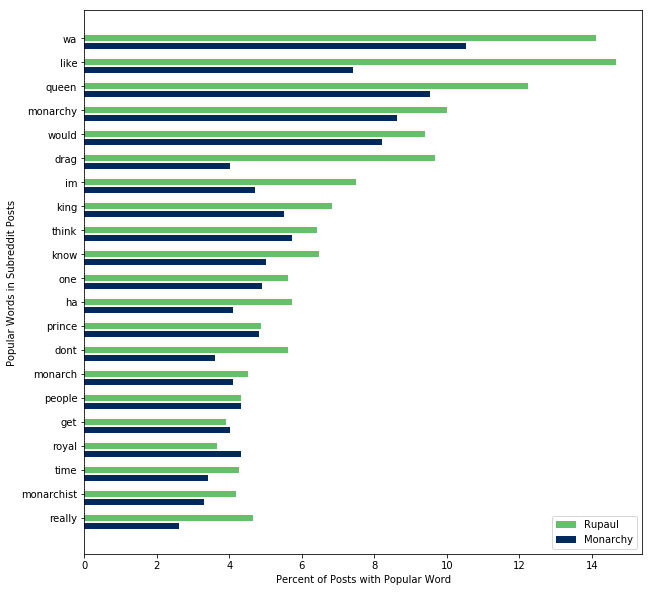

In [10]:
import numpy as np

cv = CountVectorizer()
cv.fit(X_tr_f)
eda = cv.transform(X_tr_f)
eda_set = pd.DataFrame(eda.todense(), columns = cv.get_feature_names())
eda_set['ru'] = y_train
top_words = eda_set.sum().sort_values(ascending = False)[:22]
ru_set = eda_set[eda_set['ru'] == 1] / len(post_df1)
mon_set = eda_set[eda_set['ru'] != 1] / len(post_df2)
data_to_graph = pd.DataFrame({
    'ru words': ru_set[top_words.index].sum()[1:]*100,
    'monarchy words': mon_set[top_words.index].sum()[1:]*100
})



# Graph data collected above
ig, ax = plt.subplots(figsize = (10,10) )

# set height of bar
bars1 = data_to_graph['ru words']
bars2 = data_to_graph['monarchy words']

y_pos = np.arange(len(bars1)*3)                           # create spots to put bars 0, 3, 6, etc for RU
y_pos1 = np.arange(0, len(bars1)*3, 3)                    # spots 1, 4, 7, etc for monarcy 
y_pos2 = y_pos1 + 1                                       # leave 2, 5, 8, etc blank for esthetics
words = top_words.index[1:]                               # these are the words being graphed, eliminated RDR tag
ax.barh(y_pos1, bars1, align='center',
        color='#66BF6A', ecolor='black', label = 'Rupaul')
ax.barh(y_pos2, bars2, align='center',
        color='#002A5C', ecolor='black', label = 'Monarchy')
ax.set_yticks(y_pos1)
ax.set_yticklabels(words)
ax.invert_yaxis() 
ax.set_xlabel("Percent of Posts with Popular Word")
ax.set_ylabel("Popular Words in Subreddit Posts")
plt.legend(loc = 4)                                        #puts legend in bottom corner


# Models

### Basic function to print out stats on grid search best model / parameters / fit

In [11]:
def print_grid_scores(grid_in, Xt = X_te_f, yt = y_test):
    print(grid_in.best_params_)
    print('Traing score:                 ', grid_in.best_score_)
    print('Test score / Accuracy:        ', grid_in.score(Xt,yt))
    print('Confusion Matrix:')
    print(confusion_matrix(yt, grid_in.predict(Xt)))
#    tn, fp, fn, tp = confusion_matrix(yt, grid_in.predict(Xt)).ravel()
#    print('Accuracy:          ', (tn+tp)/(tn+tp+fn+fp), '     should equal test score')

### NB and Logistic Models - with CountVectorizor & TDIFD

In [12]:
pipe1a = Pipeline([
    ('vt', CountVectorizer()),
    ('lr', LogisticRegressionCV())
])

params_grid = {
    'vt__max_features':[None, 4000, 5000],
    'vt__ngram_range':[(1,1), (1,2), (1,3), (1,4), (1,5)]
#    'vt__max_df':[1.0, .9],
#    'vt__min_df':[0.0]
}

grid = GridSearchCV(pipe1a, params_grid, verbose = 0, n_jobs = 2)
grid.fit(X_tr_f, y_train.values.ravel())   # was getting a warning b/c shape - ravel()
print_grid_scores(grid)

{'vt__max_features': 5000, 'vt__ngram_range': (1, 3)}
Traing score:                  0.9223300970873787
Test score / Accuracy:         0.9321486268174475
Confusion Matrix:
[[214  35]
 [  7 363]]


In [13]:
pipe2 = Pipeline([
    ('tv', TfidfVectorizer()), 
    ('lr', LogisticRegressionCV())
])

params_grid = {
    'tv__max_features':[None, 4000, 5000],
    'tv__ngram_range':[(1,4), (1,5), (1,6)]
}


grid2 = GridSearchCV(pipe2, params_grid, verbose = 0, n_jobs = 2)
grid2.fit(X_tr_f, y_train.values.ravel())   
print_grid_scores(grid2)


{'tv__max_features': None, 'tv__ngram_range': (1, 5)}
Traing score:                  0.9444444444444444
Test score / Accuracy:         0.9515347334410339
Confusion Matrix:
[[231  18]
 [ 12 358]]


In [14]:
pipe1b = Pipeline([
    ('vt', CountVectorizer()),
    ('nb', MultinomialNB())
])

params_grid = {
    'vt__max_features':[None, 4000, 5000],
    'vt__ngram_range':[(1,1), (1,2), (1,3), (1,4), (1,5)]
#    'vt__max_df':[1.0, .9],
#    'vt__min_df':[0.0]
}

grid1b = GridSearchCV(pipe1b, params_grid, verbose = 0, n_jobs = 3)
grid1b.fit(X_tr_f, y_train.values.ravel())   # was getting a warning b/c shape - ravel()
print_grid_scores(grid1b)

{'vt__max_features': None, 'vt__ngram_range': (1, 3)}
Traing score:                  0.947680690399137
Test score / Accuracy:         0.9644588045234249
Confusion Matrix:
[[236  13]
 [  9 361]]


In [15]:
pipe2b = Pipeline([
    ('tv', TfidfVectorizer()), 
    ('nb', MultinomialNB())
])

params_grid = {
    'tv__max_features':[None, 2000, 3000, 3500],
    'tv__ngram_range':[(1,1,), (1,2), (1,3)]
}


grid2 = GridSearchCV(pipe2b, params_grid, verbose = 0, n_jobs = 3)
grid2.fit(X_tr_f, y_train.values.ravel())   
print_grid_scores(grid2)


{'tv__max_features': 3000, 'tv__ngram_range': (1, 1)}
Traing score:                  0.947680690399137
Test score / Accuracy:         0.9515347334410339
Confusion Matrix:
[[226  23]
 [  7 363]]


> Pretty high scores already with MultinomialNB and Logistic Regression.

### RandomForestClassifier

In [16]:
pipe3 = Pipeline([
    ('vt', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

params_grid = {
    'vt__max_features':[None, 5000],
    'vt__max_df':[.975, .97, .965],
    'vt__min_df':[1],
    'vt__ngram_range':[(1,2), (1,3), (1,4)],
    'rf__n_estimators': [35, 40, 45]
}

grid3 = GridSearchCV(pipe3, params_grid, verbose = 0, n_jobs = 3)
grid3.fit(X_tr_f, y_train.values.ravel())
print_grid_scores(grid3)

{'rf__n_estimators': 45, 'vt__max_df': 0.975, 'vt__max_features': None, 'vt__min_df': 1, 'vt__ngram_range': (1, 4)}
Traing score:                  0.9147788565264293
Test score / Accuracy:         0.9305331179321487
Confusion Matrix:
[[209  40]
 [  3 367]]


In [17]:
pipe4 = Pipeline([
    ('tv', TfidfVectorizer()), 
    ('rf', RandomForestClassifier())
])

params_grid = {
    'tv__max_features':[None, 5000],
    'tv__max_df':[ .985, .98, .975],
    'tv__min_df':[1, 2],
    'tv__ngram_range':[(1,3), (1,4), (1,5)],
    'rf__n_estimators': [30, 31, 32]
}

grid4 = GridSearchCV(pipe4, params_grid, verbose = 0, n_jobs = 3)
grid4.fit(X_tr_f, y_train.values.ravel())
print_grid_scores(grid4)

{'rf__n_estimators': 30, 'tv__max_df': 0.98, 'tv__max_features': None, 'tv__min_df': 2, 'tv__ngram_range': (1, 5)}
Traing score:                  0.9115426105717368
Test score / Accuracy:         0.9353796445880452
Confusion Matrix:
[[229  20]
 [ 20 350]]


### AdaBoost

In [18]:
pipe6 = Pipeline([
    ('vt', CountVectorizer()),
    ('ada', AdaBoostClassifier())
])

ada_params = {
    'vt__ngram_range':[(1,1), (1,2), (1,3), (1,4)],
    'ada__n_estimators': [70, 75, 80],
    'ada__learning_rate':[.85, .9, .95]
}

gs = GridSearchCV(pipe6, param_grid = ada_params, n_jobs = 3)
gs.fit(X_tr_f, y_train.values.ravel())
print_grid_scores(gs)

{'ada__learning_rate': 0.85, 'ada__n_estimators': 75, 'vt__ngram_range': (1, 1)}
Traing score:                  0.8980582524271845
Test score / Accuracy:         0.9143780290791599
Confusion Matrix:
[[205  44]
 [  9 361]]


In [19]:
pipe7 = Pipeline([
    ('tv', TfidfVectorizer()), 
    ('ada', AdaBoostClassifier())
])

params_grid = {
    'tv__max_features':[2000, 2050, 2100, 2200],
    'tv__ngram_range':[(1,3), (1,4), (1,5)],
#    'tv__max_df':[ 1.0, .95],
#    'tv__min_df':[1, 2],
    'ada__n_estimators': [240, 243, 245, 247],
    'ada__learning_rate':[1, .93, .92, .91]    
}

grid7 = GridSearchCV(pipe7, params_grid, verbose = 0, n_jobs = 3)
grid7.fit(X_tr_f, y_train.values.ravel())   
print_grid_scores(grid7)

{'ada__learning_rate': 1, 'ada__n_estimators': 243, 'tv__max_features': 2050, 'tv__ngram_range': (1, 3)}
Traing score:                  0.9007551240560949
Test score / Accuracy:         0.925686591276252
Confusion Matrix:
[[216  33]
 [ 13 357]]


### BaggingClassifier

In [20]:
pipe5 = Pipeline([
    ('vt', CountVectorizer()),
    ('bag',BaggingClassifier())
])

params_grid = {
    'vt__ngram_range':[(1,1), (1,2)],
    'vt__max_features':[None],
    'vt__max_df':[ .9, 1.0],
#    'vt__min_df':[1, 2, 3],
    'bag__n_estimators': [50, 75, 100, 250, 500]
}

grid5 = GridSearchCV(pipe5, params_grid, verbose = 0, n_jobs = 3)
grid5.fit(X_tr_f, y_train.values.ravel())
print_grid_scores(grid5)

{'bag__n_estimators': 50, 'vt__max_df': 1.0, 'vt__max_features': None, 'vt__ngram_range': (1, 1)}
Traing score:                  0.9002157497303128
Test score / Accuracy:         0.9176090468497576
Confusion Matrix:
[[209  40]
 [ 11 359]]


### Gradient Boosting Classifier

In [21]:
pipe8 = Pipeline([
    ('tv', TfidfVectorizer()), 
    ('gb', GradientBoostingClassifier(random_state = 1929))
])

params_grid = {
    'tv__ngram_range':[(1,2), (1,3), (1,4)],
    'tv__max_features':[None],
    'tv__max_df':[ 1.0, .95],
    'tv__min_df':[2, 3],
    'gb__max_depth': [3, 4],
    'gb__loss':['exponential'],
#    'gb__criterion':['friedman_mse', 'mse', 'mae'],
    'gb__learning_rate':[.9, .8, .7],
    'gb__n_estimators': [1000, 2000, 3000] ,
    'gb__subsample':[1.0],
    'gb__max_features':[None]
}

grid8 = GridSearchCV(pipe8, params_grid, verbose = 0, n_jobs = 3)
grid8.fit(X_tr_f, y_train.values.ravel())   
print_grid_scores(grid8)

{'gb__learning_rate': 0.8, 'gb__loss': 'exponential', 'gb__max_depth': 4, 'gb__max_features': None, 'gb__n_estimators': 3000, 'gb__subsample': 1.0, 'tv__max_df': 1.0, 'tv__max_features': None, 'tv__min_df': 3, 'tv__ngram_range': (1, 3)}
Traing score:                  0.9115426105717368
Test score / Accuracy:         0.9305331179321487
Confusion Matrix:
[[218  31]
 [ 12 358]]


# Overall, the Naive Bayes Model with Count Vectorizer was Best Performing 

> The fit is relatively good at above 96% accuracy on the testing set.  Accuracy of 94-95% on the training set.  Since these values are close, it implies a nice fit.

# Reviewing the Misclassifications

> This printout below shows posts that were misclassified in the test dataset by the best model (grid1b, NB with CV).

In [22]:
yhat = grid1b.predict(X_te_f)
df_out = pd.DataFrame({
    'X':X_te_f,
    'y':y_test['y'],
    'yhat':yhat
})

df_out['Misclass'] = abs(df_out['y'] - df_out['yhat'])
df_out[df_out['Misclass']==1]

,X,y,yhat,Misclass
1819,dont want puppet menteri besar raja perlis,0,1,1
320,clinic near start free std screening,1,0,1
951,work hospital family asks prognosis,1,0,1
1610,thought wa kinda funny replace prodemocracy an...,0,1,1
364,feed horse,1,0,1
442,soooo ive found product supermarket spain,1,0,1
1869,la royale french royalist song,0,1,1
434,wa robin williams defining role,1,0,1
1680,weve hit subscriber post subscriber httpsmyout...,0,1,1
520,saw showerthoughts immediately meme came mind,1,0,1


# Using the Model

### Predicting specific phrases -- which subreddit would this phrase be most likely to show up in?

In [23]:
def pred_phrase(list_in, grid_in = grid1b):
    n = max([len(each) for each in list_in])
    for each in list_in:
        pr = grid_in.predict([each])
        print(each, end = ' ' * (n+4 - len(each)))
        if pr:
            print ("Rupaul")
        else:
            print ("General Monarchy")
        print(' ')

In [24]:
list_to_test = ['queen', 'mother', 'queen mother', 'coronation', 'crown', 'elizabeth', 'william', 'willam', 'miss vanjy didnt get a crown', 'work', 'work william', 'catherine work', 'jubilee', 'jujube']

In [25]:
pred_phrase(list_to_test)

queen                           Rupaul
 
mother                          Rupaul
 
queen mother                    Rupaul
 
coronation                      General Monarchy
 
crown                           General Monarchy
 
elizabeth                       General Monarchy
 
william                         General Monarchy
 
willam                          Rupaul
 
miss vanjy didnt get a crown    Rupaul
 
work                            Rupaul
 
work william                    General Monarchy
 
catherine work                  General Monarchy
 
jubilee                         General Monarchy
 
jujube                          Rupaul
 


> How close is The Crown reddit to either Rupaul or Monarchist?  Slightly over 50%

In [26]:
print(grid1b.predict(X_crown).mean())

0.5459459459459459


# Summary

> In general, I was surprised that a more simple model (Naive Bayes) was the most powerful predictor.  I did a lot of hypertuning of parameters on the ensemble models, but they never reached the level of predicting power than either NB or Logistic regression had.

> The initial score for a basic model without much advanced analysis was just under 90%.  After initial model building, testing and parameter tuning, I reached a score of 93% on NB and 90-92% on other models.  A second pass at the process yieled two additional areas where I could make changes:  eliminating records that had all stop words and so were blank data going through the model, and tuning on ngrams.  The ngram tuning provided a 2.5% boost to my best model and the removal of the blank posts added another 0.5%.

# One final model - testing what we learned in class on Friday

### Using a sentiment analyzer, the score was unchanged.  Using average word length or post length, the predictive power of the model decreased.

In [27]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('hi how are you')

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [28]:
class PosScore(BaseEstimator, TransformerMixin):

    sia = SentimentIntensityAnalyzer()

    def __init__(self):
        pass
    
    def get_pos(self, line):
        return sia.polarity_scores(line)['pos']
    
    def transform(self, df):
        return np.array(df.apply(self.get_pos)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [29]:
class AverageWordLength(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def avg_word_length(self, line):
        return np.mean([len(each) for each in line.split()])
    
    def transform(self, df):
        return np.array(df.apply(self.avg_word_length)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [30]:
class PostLength(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def post_length(self, line):
        return len(line) 
    
    def transform(self, df):
        return np.array(df.apply(self.post_length)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [31]:
pipe55 = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer(ngram_range=(1,3))),
#        ('awl', AverageWordLength()),
#        ('gc', PosScore()),
#        ('pl', PostLength())
    ])),
    ('nb', MultinomialNB())
])

pipe55.fit(X_tr_f, y_train.values.ravel())
print(pipe55.score(X_tr_f, y_train), pipe55.score(X_te_f, y_test))

0.9967637540453075 0.9644588045234249
